<a href="https://colab.research.google.com/github/Lawisss/Top-30-Investment-Banks-Analysis/blob/main/Top_30_Investment_Banks_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Top 30 Investment Banks Volume stocks Analysis

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1) Data preprocessing

In [6]:
 # Boucle qui récupère le nom de la banque et les rajoutes aux dataframes

import glob
import os.path
from os.path import splitext

files = glob.glob('/content/stocks/*.csv')
liste = []

for file in sorted(files):
  filenames, _ = os.path.splitext(file) 
  split = filenames.split('_')
  df_stocks = pd.read_csv(file)
  new_df_stocks = df_stocks.assign(bank=split[3])
  liste.append(new_df_stocks)

stocks = pd.concat(liste)

In [7]:
print(stocks.isna().values.any())
print(stocks.shape)

False
(125303, 7)


In [8]:
stocks = stocks.set_index('date')

In [9]:
stocks.drop(stocks.loc[stocks.index > '2017-12-31'].index, inplace=True)

In [10]:
stocks.drop(stocks.loc[stocks.index < '2009-01-01'].index, inplace=True)

In [11]:
stocks.drop(stocks.loc[stocks.volume == 0].index, inplace=True)

In [12]:
stocks.index = pd.to_datetime(stocks.index, format='%Y-%m').to_period('M')

In [13]:
# Part de marché + volatilité glissante

market_share = (stocks.groupby(['date', 'bank'])['volume'].sum() / stocks.groupby(['date'])['volume'].sum()) * 100
vol_market_share = market_share.rolling(2).std()

market_share = pd.DataFrame(market_share)
vol_market_share = pd.DataFrame(vol_market_share)

add_df = market_share.merge(vol_market_share, on=['date', 'bank'])
stocks = stocks.merge(add_df, on=['date', 'bank'])
stocks = stocks.rename(columns={"volume_x": "market share", "volume_y": "vol market share"})

In [14]:
stocks

,open,high,low,close,volume,bank,market share,vol market share
date,,,,,,,,
2009-01,0.26,0.30,0.2500,0.30,22800,AI,0.028865,NaN
2009-01,0.27,0.33,0.2700,0.30,23500,AI,0.028865,NaN
2009-01,0.30,0.31,0.2500,0.26,30600,AI,0.028865,NaN
2009-01,0.21,0.23,0.1800,0.18,57600,AI,0.028865,NaN
2009-01,0.19,0.20,0.1500,0.16,44700,AI,0.028865,NaN
...,...,...,...,...,...,...,...,...
2017-12,12.59,12.68,12.4300,12.66,1241990,WETF,4.495036,1.070614
2017-12,12.53,12.68,12.4550,12.62,780273,WETF,4.495036,1.070614
2017-12,12.61,12.68,12.4900,12.53,773905,WETF,4.495036,1.070614


In [15]:
stocks_analysis = stocks.loc[(stocks.index > '2008-12') & (stocks.index < '2017-01')]
stocks_analysis

,open,high,low,close,volume,bank,market share,vol market share
date,,,,,,,,
2009-01,0.26,0.3000,0.25,0.30,22800,AI,0.028865,NaN
2009-01,0.27,0.3300,0.27,0.30,23500,AI,0.028865,NaN
2009-01,0.30,0.3100,0.25,0.26,30600,AI,0.028865,NaN
2009-01,0.21,0.2300,0.18,0.18,57600,AI,0.028865,NaN
2009-01,0.19,0.2000,0.15,0.16,44700,AI,0.028865,NaN
...,...,...,...,...,...,...,...,...
2016-12,11.53,11.5700,11.22,11.47,2453518,WETF,7.271188,5.102755
2016-12,11.45,11.8700,11.45,11.70,2110192,WETF,7.271188,5.102755
2016-12,11.86,11.9701,11.46,11.48,1205436,WETF,7.271188,5.102755


### 2) Analyse descriptive

Quelles sont les 5 premières banques en termes de volume mensuel échangé ?

In [16]:
# Moyenne par mois

sum_month = stocks_analysis.groupby(['bank', stocks_analysis.index.month])['volume'].agg(['sum'])
sum_month.groupby(['bank'])['sum'].mean().sort_values(ascending=False)[:5] 

bank
MS      1.411480e+09
SCHW    8.727674e+08
GS      4.863346e+08
ETFC    3.570742e+08
AMTD    2.969821e+08
Name: sum, dtype: float64

In [17]:
# Total sur l'année

stocks_analysis.groupby(['bank'])['volume'].sum().sort_values(ascending=False)[:5]

bank
MS      16937758014
SCHW    10473208770
GS       5836015732
ETFC     4284890273
AMTD     3563784899
Name: volume, dtype: int64

Morgan Stanley, Charles Schwab, Goldman Sachs, E-trade, TD Ameritrade

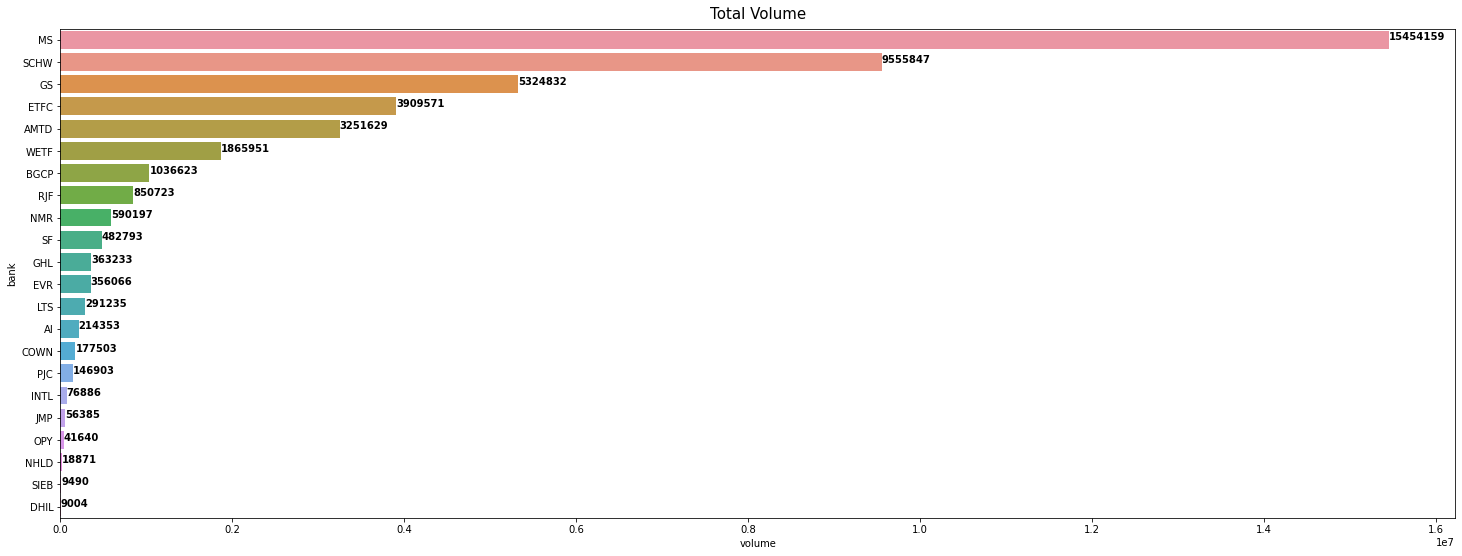

In [18]:
bar, ax = plt.subplots(figsize=(25,9))

sorted_nb = stocks_analysis.groupby(['bank'])['volume'].sum().sort_values(ascending=False)
ax = sns.barplot(x=stocks_analysis['volume'], y=stocks_analysis['bank'], order=list(sorted_nb.index), orient='h', ci=None)
plt.title('Total Volume', pad=10, fontsize=15)

for rect in ax.patches:
    ax.text(rect.get_width(), rect.get_y() + rect.get_height() / 2, round(rect.get_width()), weight='bold')

(0.0, 100000000.0)

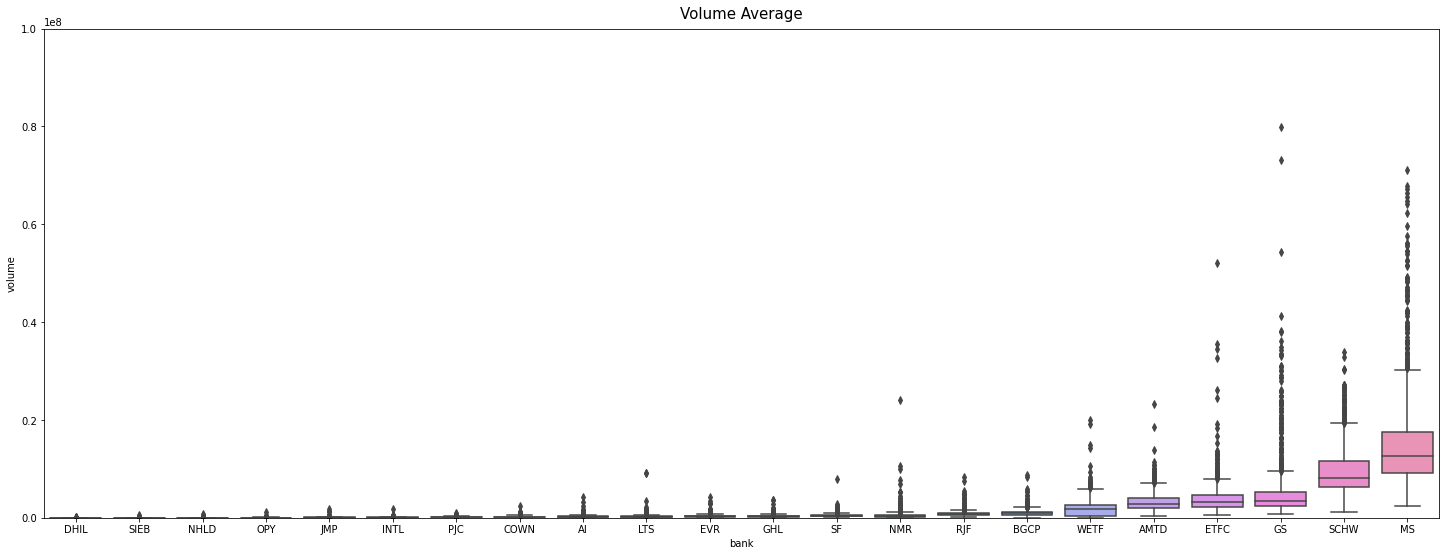

In [19]:
bar, ax = plt.subplots(figsize=(25,9))

sorted_nb = stocks_analysis.groupby(['bank'])['volume'].mean().sort_values()
ax = sns.boxplot(x=stocks_analysis['bank'], y=stocks_analysis['volume'], order=list(sorted_nb.index))

plt.title('Volume Average', pad=10, fontsize=15)
ax.set_ylim(0, 1e8)

Pouvez-vous identifier des groupes de banques ayant des comportements similaires ?

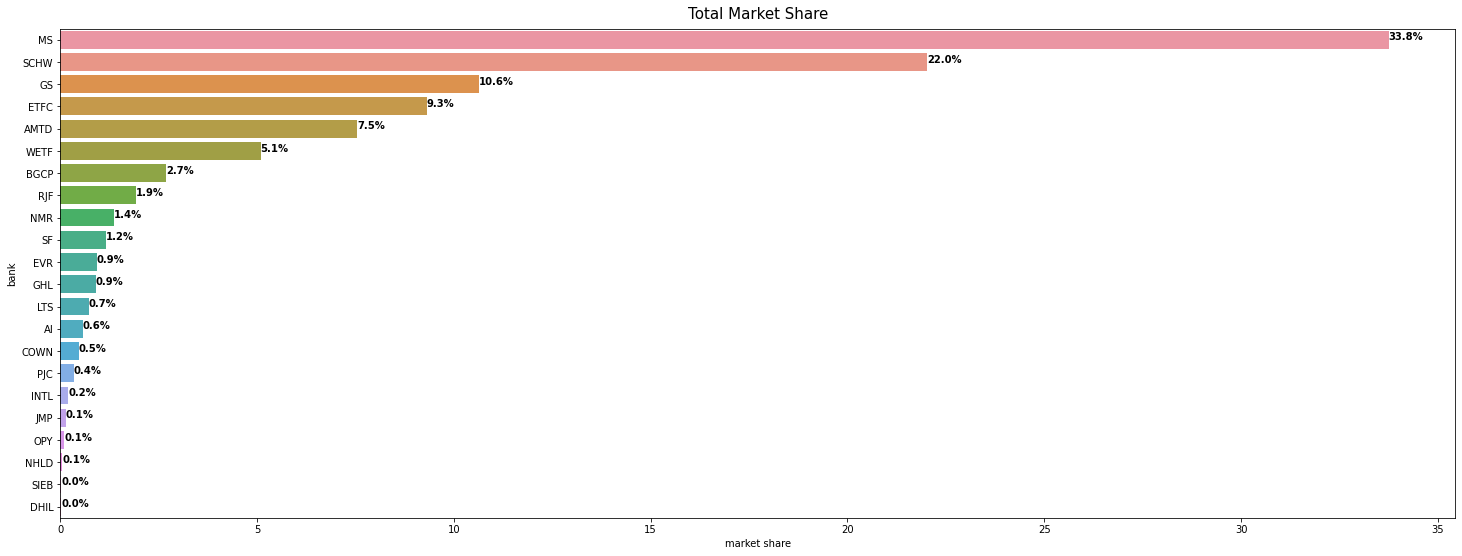

In [20]:
bar, ax = plt.subplots(figsize=(25,9))

sorted_nb = stocks_analysis.groupby(['bank'])["market share"].sum().sort_values(ascending=False)
ax = sns.barplot(x=stocks_analysis["market share"], y=stocks_analysis['bank'], order=list(sorted_nb.index), orient='h', ci=None)
plt.title('Total Market Share', pad=10, fontsize=15)

for rect in ax.patches:
    ax.text(rect.get_width(), rect.get_y() + rect.get_height() / 2, "%.1f%%"% round(rect.get_width(),1), weight='bold')

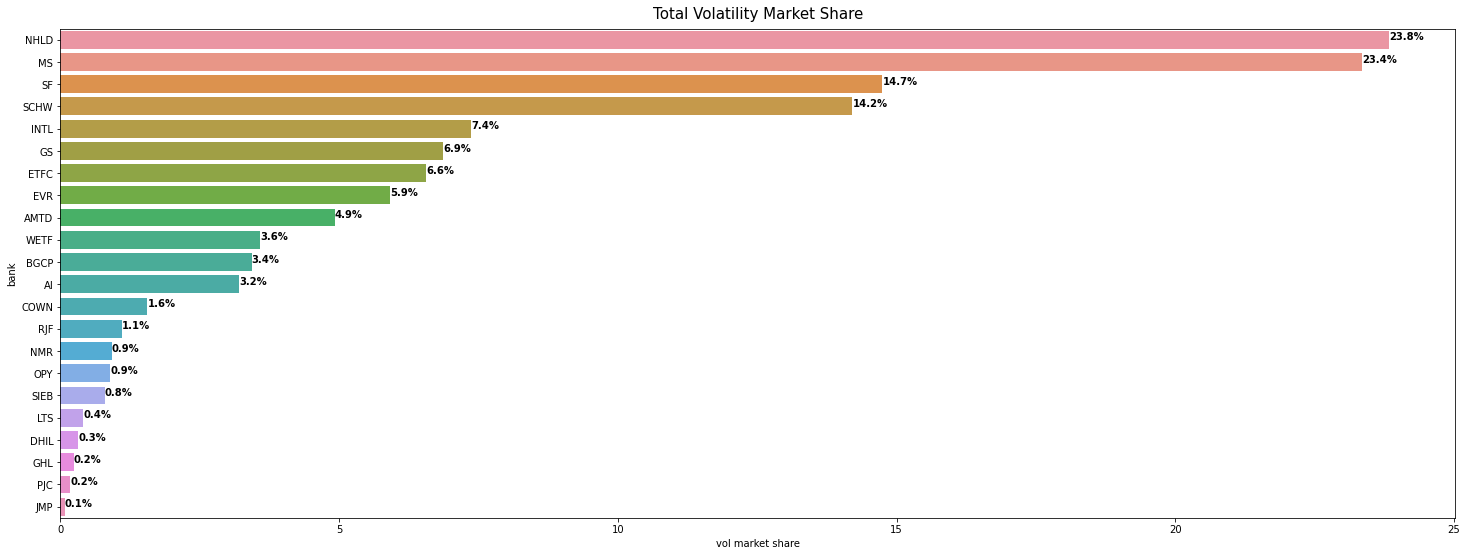

In [21]:
bar, ax = plt.subplots(figsize=(25,9))

sorted_nb = stocks_analysis.groupby(['bank'])["vol market share"].sum().sort_values(ascending = False)
ax = sns.barplot(x=stocks_analysis["vol market share"], y=stocks_analysis['bank'], order=list(sorted_nb.index), orient='h', ci=None)
plt.title('Total Volatility Market Share', pad=10, fontsize=15)

for rect in ax.patches:
    ax.text(rect.get_width(), rect.get_y() + rect.get_height() / 2, "%.1f%%"% round(rect.get_width(),1), weight='bold')

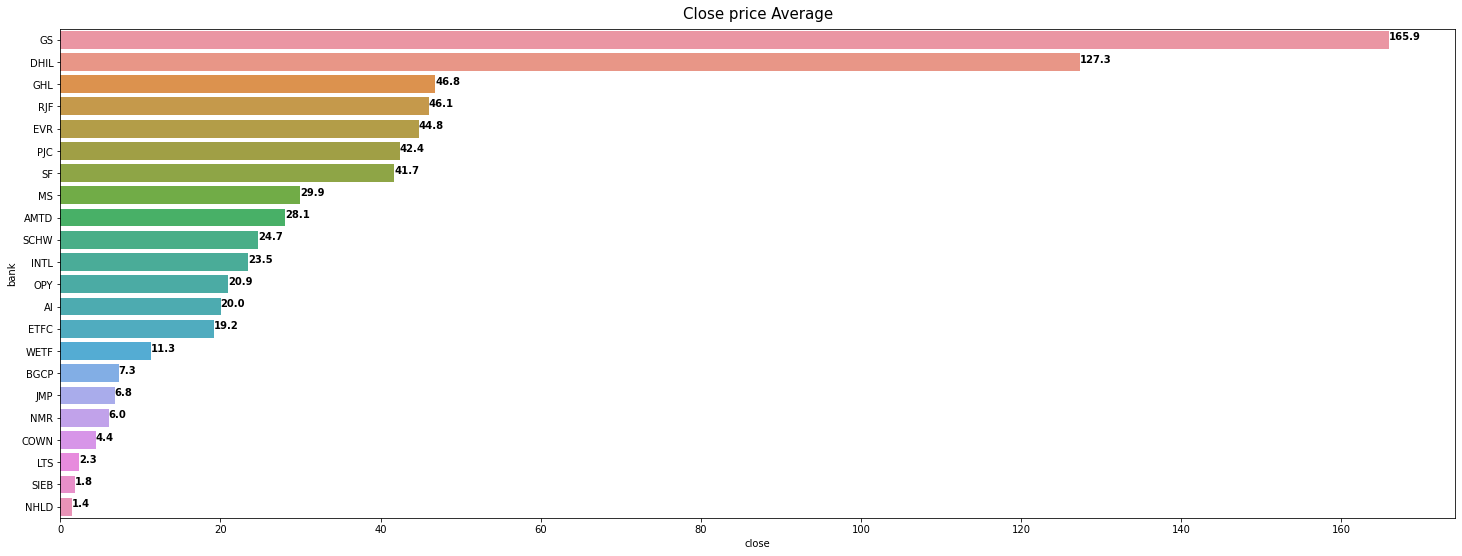

In [22]:
bar, ax = plt.subplots(figsize=(25,9))

sorted_nb = stocks_analysis.groupby(['bank'])['close'].mean().sort_values(ascending = False)
ax = sns.barplot(x="close", y="bank", data=stocks_analysis, ci=None, orient='h', order=list(sorted_nb.index))
plt.title('Close price Average', pad=10, fontsize=15)

for rect in ax.patches:
    ax.text(rect.get_width(), rect.get_y() + rect.get_height() / 2, round(rect.get_width(),1), weight='bold')

On constate que le top 5 des banques en terme de volume mensuel, possèdent les parts de marché et les volatilités associées les plus importantes.

1er groupe : Morgan Stanley (MS), Charles Schwab (SCHW), Goldman Sachs (GS), E-trade (ETFC), TD Ameritrade (AMTD).

2ème groupe : BGC Partners (BGCP) et WisdomTree Investments (WEFT).

3ème groupe : Nomura Holdings Inc ADR (NMR), Raymond James Financial (RJF) et de Stifel Financial (SF)

4ème groupe : Les autres

Parmi toutes les caractéristiques qui ont été créées, quelles sont celles qui sont corrélées ?

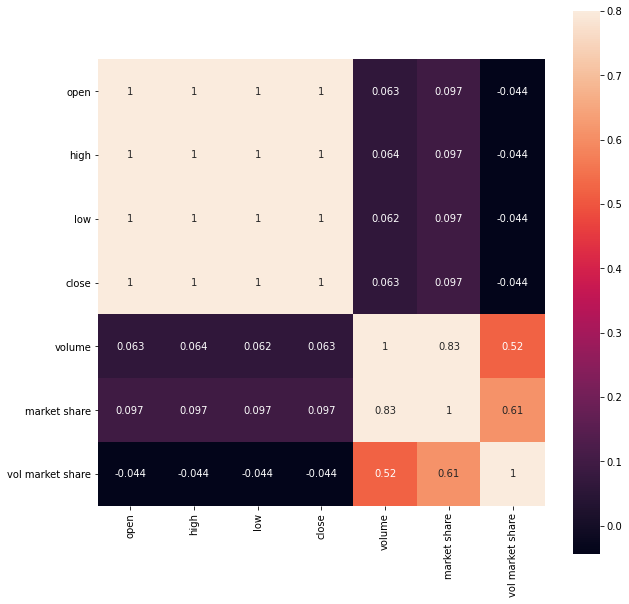

In [23]:
# Matrice de corrélation

corrmat = stocks.corr(method="pearson")
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, vmax=0.8, square=True, annot=True)
plt.show()

Les caractéristiques corrélées sont : le volume, la part de marché mensuelle de chaque banque, et la volatilité du volume mensuel de la part de marché.

Lesquelles pourraient être utilisées pour prévoir la tendance et le volume pour le mois suivant ?

Ceux citer au dessus.

### 3) Réalisation des prédictions (Classification / Régression)

#### Preprocessing

In [24]:
pmi = pd.read_csv('/content/macro/PMI.csv')
sp500 = pd.read_csv('/content/macro/sp500.csv', header=8)
sp500futures = pd.read_csv('/content/macro/sp500futures.csv',header=10)

pmi = pmi.rename(columns={'Date' : 'date'})
pmi.head()

,date,PMI
0,2019-02-01,54.2
1,2019-01-01,56.6
2,2018-12-01,54.3
3,2018-11-01,58.8
4,2018-10-01,57.5


In [25]:
pmi = pmi.set_index('date')
sp500 = sp500.set_index('date')
sp500futures = sp500futures.set_index('date')

In [26]:
pmi.drop(pmi.loc[pmi.index > '2017-12-31'].index, inplace=True)
sp500.drop(pmi.loc[pmi.index > '2017-12-31'].index, inplace=True)
sp500futures.drop(pmi.loc[pmi.index > '2017-12-31'].index, inplace=True)

In [27]:
pmi.drop(pmi.loc[pmi.index < '2009-01-01'].index, inplace=True)
sp500.drop(sp500.loc[sp500.index < '2009-01-01'].index, inplace=True)
sp500futures.drop(sp500futures.loc[sp500futures.index < '2009-01-01'].index, inplace=True)

In [28]:
pmi.index = pd.to_datetime(pmi.index, format='%Y-%m').to_period('M')
sp500.index = pd.to_datetime(sp500.index, format='%Y-%m').to_period('M')
sp500futures.index = pd.to_datetime(sp500futures.index, format='%Y-%m').to_period('M')

In [29]:
pmi = pd.DataFrame(pmi.groupby('date').mean())
sp500 = pd.DataFrame(sp500.groupby('date').mean())
sp500futures = pd.DataFrame(sp500futures.groupby('date').mean())

In [30]:
pmi_new = pmi.merge(sp500, on='date')
sp500_pmi = pmi_new.merge(sp500futures, on='date')
stocks_new = stocks.merge(sp500_pmi, on='date')

In [31]:
new_col = stocks_new.columns.values
new_col[9] = 'sp500'
new_col[10] = 'sp500futures'

stocks_new.columns = new_col

In [32]:
stocks_new = stocks_new.drop_duplicates()
stocks_new

,open,high,low,close,volume,bank,market share,vol market share,PMI,sp500,sp500futures
date,,,,,,,,,,,
2009-04,0.21,0.26,0.2000,0.26,78100,AI,0.033327,0.011330,39.5,851.290556,845.535714
2009-04,0.25,0.26,0.2300,0.25,18600,AI,0.033327,0.011330,39.5,851.290556,845.535714
2009-04,0.27,0.36,0.2600,0.30,67400,AI,0.033327,0.011330,39.5,851.290556,845.535714
2009-04,0.31,0.38,0.3000,0.31,46500,AI,0.033327,0.011330,39.5,851.290556,845.535714
2009-04,0.32,0.34,0.3000,0.30,27100,AI,0.033327,0.011330,39.5,851.290556,845.535714
...,...,...,...,...,...,...,...,...,...,...,...
2017-12,12.59,12.68,12.4300,12.66,1241990,WETF,4.495036,1.070614,59.3,2664.340500,2667.625000
2017-12,12.53,12.68,12.4550,12.62,780273,WETF,4.495036,1.070614,59.3,2664.340500,2667.625000
2017-12,12.61,12.68,12.4900,12.53,773905,WETF,4.495036,1.070614,59.3,2664.340500,2667.625000


#### Prédiction de la tendance du volume mensuel total (à la hausse ou à la baisse) pour chaque mois entre 2017 et 2018.

Preprocessing classification

In [33]:
X = stocks_new[['market share', 'vol market share', 'PMI', 'sp500', 'sp500futures']]
y = stocks_new['volume']

print(X.head())
print(y.head())

         market share  vol market share   PMI       sp500  sp500futures
date                                                                   
2009-04      0.033327           0.01133  39.5  851.290556    845.535714
2009-04      0.033327           0.01133  39.5  851.290556    845.535714
2009-04      0.033327           0.01133  39.5  851.290556    845.535714
2009-04      0.033327           0.01133  39.5  851.290556    845.535714
2009-04      0.033327           0.01133  39.5  851.290556    845.535714
date
2009-04    78100
2009-04    18600
2009-04    67400
2009-04    46500
2009-04    27100
Freq: M, Name: volume, dtype: int64


In [34]:
# Regroupe les sommes totales des caractéristiques par mois + évaluation des variations de 2009 à 2018 (+/True et -/False)

X = X.groupby('date').sum()
X = (X.diff() > 0)

In [35]:
# Regroupe les sommes totales des volumes par mois + évaluation des variations de 2009 à 2018 (+/True et -/False)

y = y.groupby('date').sum()
y = (y.diff() > 0)

In [36]:
X

,market share,vol market share,PMI,sp500,sp500futures
date,,,,,
2009-04,False,False,False,False,False
2009-05,False,False,False,False,False
2009-06,False,False,False,False,False
2009-07,True,True,True,True,True
2009-08,False,True,True,True,True
...,...,...,...,...,...
2017-08,True,True,True,True,True
2017-09,False,False,False,False,False
2017-10,True,True,True,True,True


Conception de la classification

In [37]:
X_train = X.loc[X.index < '2017-01']
X_test = X.loc[X.index >= '2017-01']

y_train = y[y.index < '2017-01']
y_test = y[y.index >= '2017-01']

In [38]:
# XGBClassifier + CV

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

lgbc = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', 
                                      random_state=42),
                    param_grid={'n_estimators': [10, 20, 50, 100],
                               'learning_rate':[0.1, 1/4, 1/2, 3/4]},
                    scoring='neg_log_loss', 
                    cv = 5, 
                    n_jobs = 1)

lgbc.fit(X_train, y_train, eval_metric=["logloss"], eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=5, verbose=0)

print(lgbc.best_params_)

best_lgbc = lgbc.best_estimator_
print(best_lgbc)

{'learning_rate': 0.75, 'n_estimators': 10}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.75, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [39]:
y_pred = best_lgbc.predict(X_test)

Affichage des résultats

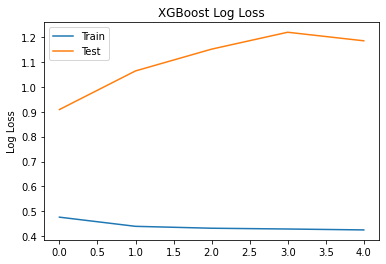

In [41]:
# Affichage des résultats d'évaluations pour la métrique à utiliser

results = best_lgbc.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [42]:
#from sklearn.linear_model import SGDClassifier
#from sklearn.model_selection import GridSearchCV

#lgbc = GridSearchCV(SGDClassifier(penalty = 'elasticnet', 
                                  #learning_rate = 'optimal',
                                  #loss = 'log'),
                    #param_grid = {'alpha' : [0.1, 1/4, 1/2, 1, 2], 
                                  #'l1_ratio' : [0.1, 1/4, 1/2, 3/4]},
                    #cv = 5, 
                    #n_jobs = 1)

#lgbc.fit(X_train, y_train)

#print(lgbc.best_params_)

#best_lgbc = lgbc.best_estimator_
#print(best_lgbc)

#y_pred = best_lgbc.predict(X_test)

In [43]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import GridSearchCV

#lgbc = GridSearchCV(RandomForestClassifier(),
                    #param_grid = {'n_estimators': [10, 20, 50, 100],
                                  #'min_samples_leaf': [3, 4, 5]},
                    #cv = 5, 
                    #n_jobs = 1)

#lgbc.fit(X_train, y_train)

#print(lgbc.best_params_)

#best_lgbc = lgbc.best_estimator_
#print(best_lgbc)

#y_pred = best_lgbc.predict(X_test)

In [45]:
# Estimation du modèle
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, precision_score, recall_score

print("Accuracy:", accuracy_score(y_test,y_pred))
print("Precision:", precision_score(y_test,y_pred))
print("Recall:", recall_score(y_test,y_pred))
print("F1_score:", f1_score(y_test,y_pred))

Accuracy: 0.4166666666666667
Precision: 0.4
Recall: 0.3333333333333333
F1_score: 0.3636363636363636


[Text(0, 0.5, 'Down'), Text(0, 1.5, 'Up')]

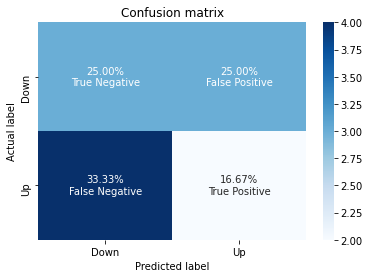

In [46]:
# Estimation de la qualité du classificateur

from sklearn.metrics import classification_report, confusion_matrix

fig, ax = plt.subplots()

cf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_percentages, group_names)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(pd.DataFrame(cf_matrix), annot=labels, cmap="Blues" ,fmt='')

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up'])
ax.yaxis.set_ticklabels(['Down', 'Up'])

In [47]:
def plot_roc_curve(fper, tper):
    plt.figure(figsize=(15,10))
    roc_auc = auc(fper, tper)
    plt.plot(fper, tper, color='orange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc = 'lower right')
    plt.show()

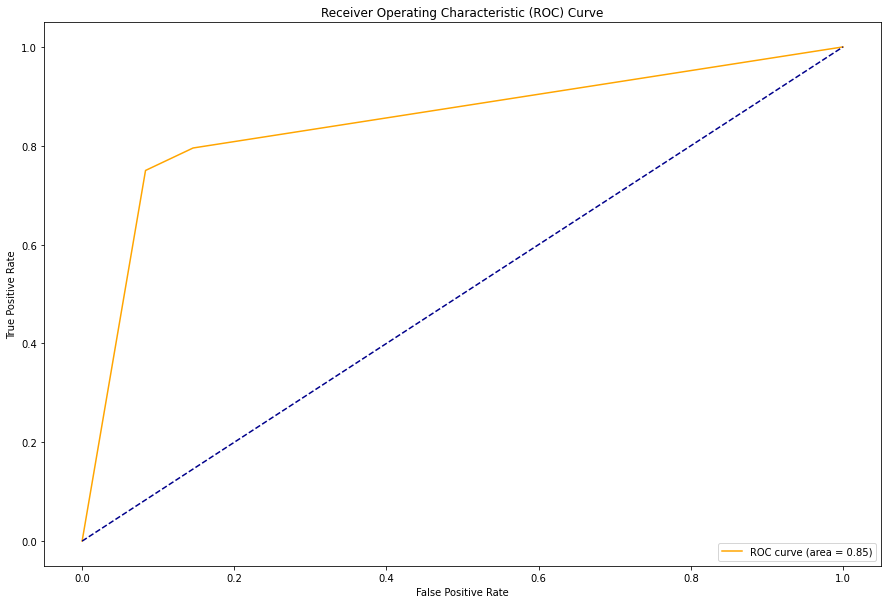

In [51]:
# Evalution n°2 de la qualité du classificateur

from sklearn.metrics import roc_curve, auc

probs = best_lgbc.predict_proba(X_train)  
probs = probs[:, 1]  
fper, tper, thresholds = roc_curve(y_train, probs) 
plot_roc_curve(fper, tper)

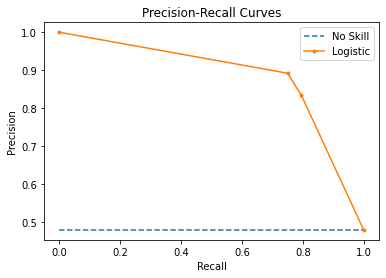

In [52]:
# Evalution n°3 de la qualité du classificateur

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_train, probs)

no_skill = len(y_train[y_train==1]) / len(y_train)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

Prédiction des valeurs du volume total pour le mois suivant sur la période 2017-2018. 


Preprocessing régression

In [53]:
X = stocks_new[['market share', 'vol market share', 'PMI', 'sp500', 'sp500futures']]
y = stocks_new['volume']

X_train = X[X.index < '2017-01']
X_test = X[X.index >= '2017-01']

y_train = y[y.index < '2017-01']
y_test = y[y.index >= '2017-01']

Conception régression

In [54]:
# XGBRegressor + CV

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgbr = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                   param_grid={'n_estimators': [50,100,150],
                               'learning_rate':[0.01, 0.05, 0.1]},
                   scoring='neg_mean_squared_error', 
                   cv=5)

xgbr.fit(X_train, 
         y_train, 
         eval_metric="rmse", 
         early_stopping_rounds=15,
         eval_set=[(X_train, y_train), (X_test, y_test)], 
         verbose=False)

print(xgbr.best_params_)

best_xgbr = xgbr.best_estimator_
print(best_xgbr)

{'learning_rate': 0.05, 'n_estimators': 150}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


In [56]:
y_pred = best_xgbr.predict(X_test)

Affichage des résultats

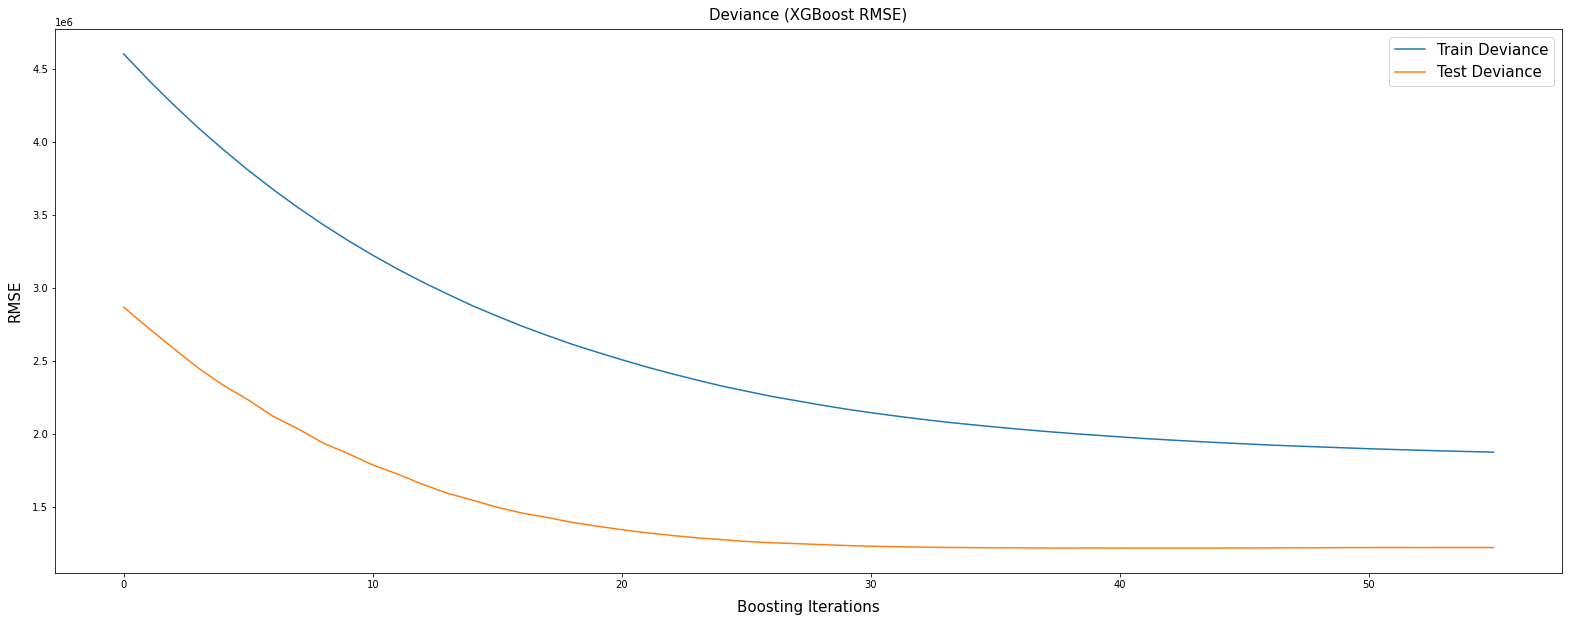

In [57]:
# Affichage des résultats d'évaluations pour la métrique à utiliser

results = best_xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])

plt.figure(figsize=(27,10))
x_axis = range(0, epochs)
plt.plot(x_axis, results['validation_0']['rmse'], label='Train Deviance')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test Deviance')
plt.legend(loc='best', fontsize=15)
plt.xlabel('Boosting Iterations', labelpad=10, fontsize=15)
plt.ylabel('RMSE', labelpad=10, fontsize=15)
plt.title('Deviance (XGBoost RMSE)', pad=10, fontsize=15)
plt.show()

In [58]:
# Estimation du modèle

from sklearn.metrics import mean_squared_error

score = best_xgbr.score(X_train, y_train)  
print("Training score: ", score)

score = best_xgbr.score(X_test, y_test)  
print("Test score: ", score)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f (Critère d'exactitude à bonne échelle)" % (mse**(1/2.0)))

Training score:  0.7987850276861796
Test score:  0.7889819959904256
MSE: 1485427233157.86
RMSE: 1218781.04 (Critère d'exactitude à bonne échelle)


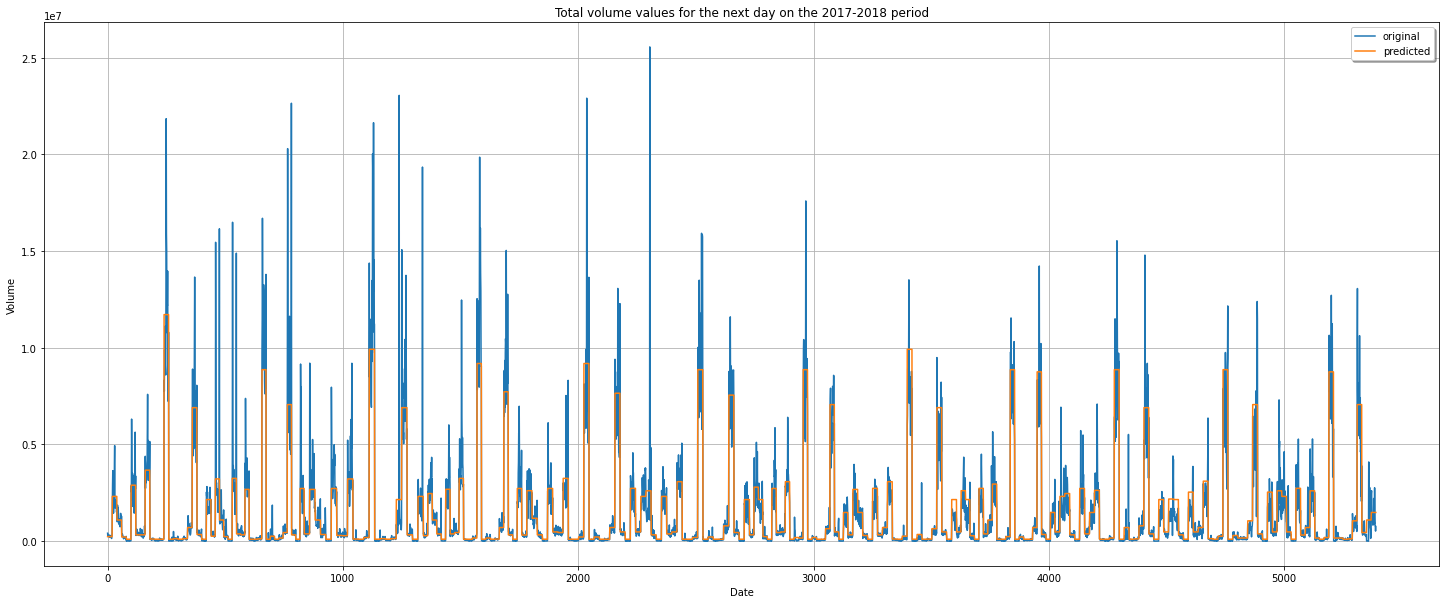

In [59]:
# Affichage prédiction par jours

fig = plt.figure(figsize=(25,10))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Total volume values for the next day on the 2017-2018 period")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

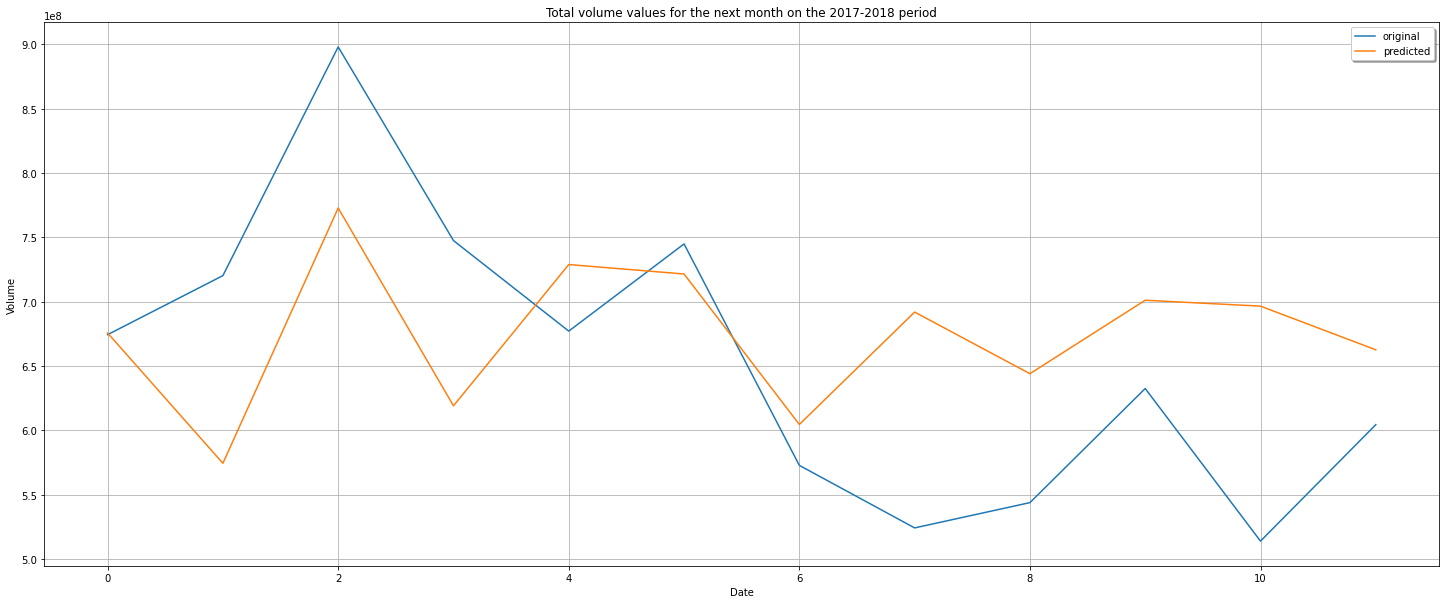

In [60]:
# Affichage prédiction par mois

fig = plt.figure(figsize=(25,10))
y_pred = pd.DataFrame(y_pred).set_index(y_test.index)
x_ax = range(len(y_test.groupby('date').sum()))
plt.plot(x_ax, y_test.groupby('date').sum(), label="original")
plt.plot(x_ax, y_pred.groupby('date').sum(), label="predicted")
plt.title("Total volume values for the next month on the 2017-2018 period")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

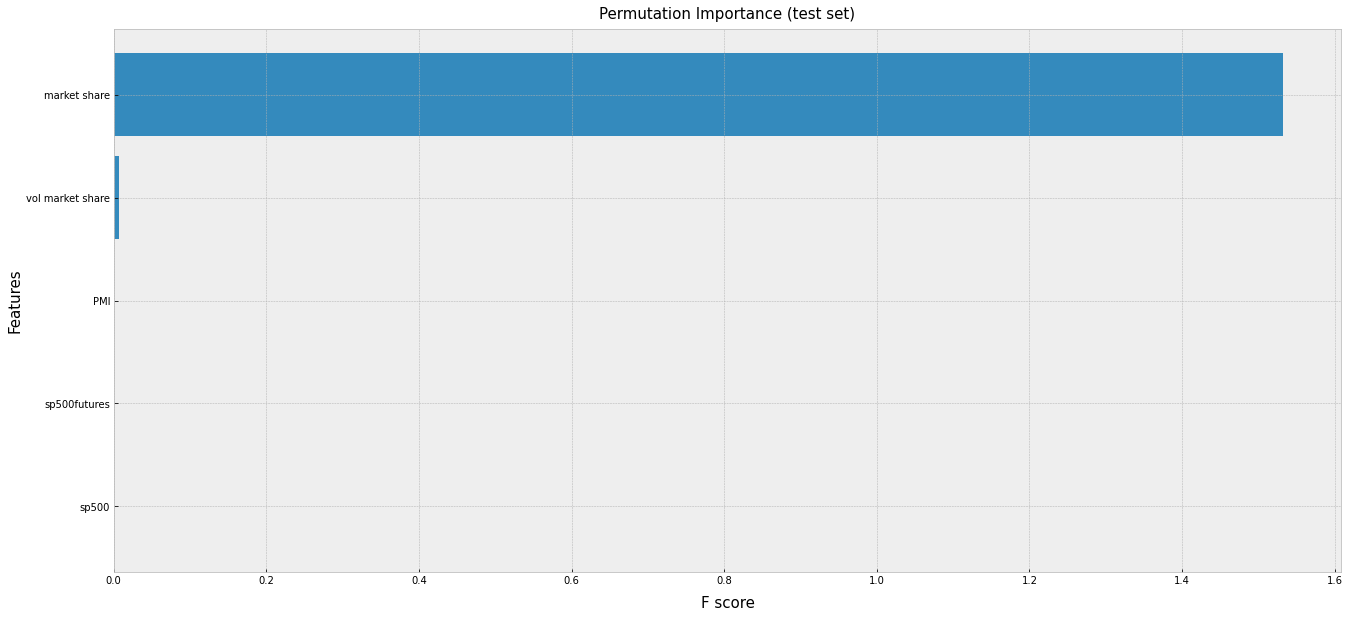

In [61]:
# Importance d'une variable par rapport au modèle

from sklearn.inspection import permutation_importance

result = permutation_importance(best_xgbr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

plt.style.use("bmh")
plt.figure(figsize=(22,10))
ax = plt.gca()
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Importance (test set)", pad=10, fontsize=15)
plt.xlabel('F score', labelpad=10, fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

In [62]:
!pip install shap

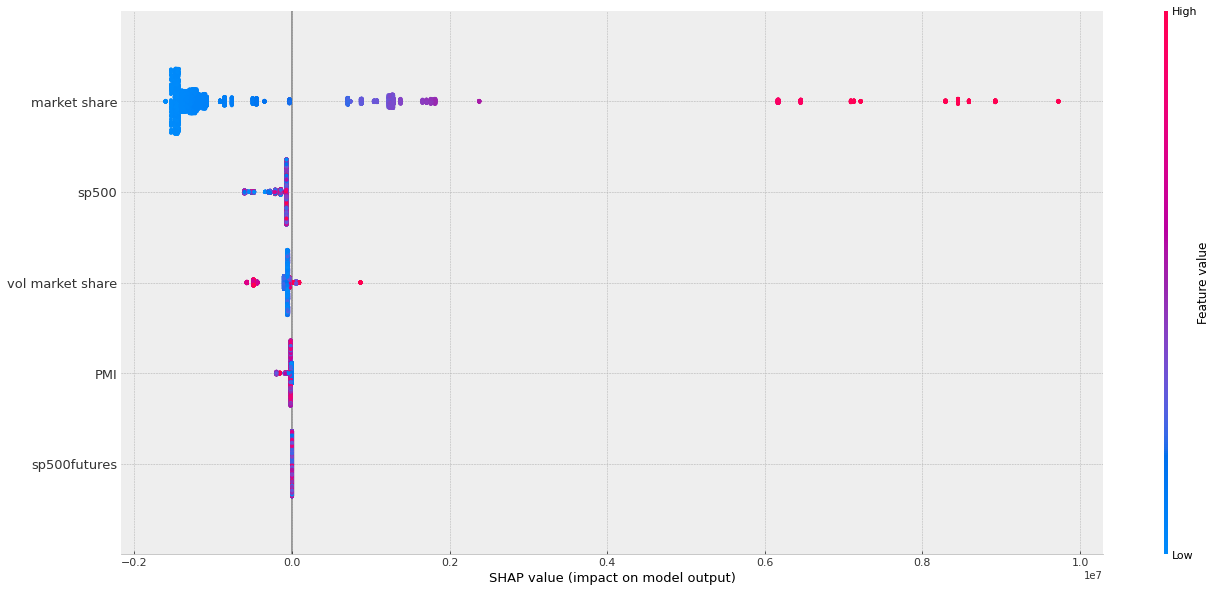

In [63]:
# Pouvoir prédictif d'une variable sur le modèle en fonction de sa taille

import shap

explainer = shap.TreeExplainer(best_xgbr)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_size=(22,10))